In [82]:
from collections import Counter
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("font", size=14)

data_path = Path('/home/sudiptra/Downloads/WolliesX_DataScience_Test (data).csv')


In [83]:
# Explore the data

In [84]:
all_cols = ["age", "job", "marital", "education", "default", "housing", "loan",
            "campaign", "contact", "month", "day_of_week", "duration",
            "previous", "poutcome", "cons.price.idx", "cons.conf.idx", "y"]

categorical_features = ['job', 'marital', 'education', 'default', 'housing',
                        'loan', 'contact', 'month', 'day_of_week', 'poutcome',
                        ]

campaign_related_features = ["contact", "month", "day_of_week", "duration"]
int_columns = ['campaign', 'previous']

all_cols_set = set(all_cols)
all_cols_set.remove('y')
ordinal_features = list(all_cols_set - set(categorical_features)
                        - set(int_columns))
converters = {k: str for k in categorical_features}
    
for f in ordinal_features:
    converters[f] = np.float32
# Checked that campaign has on 0s and 1s using
converters['campaign'] = np.int8
converters['y'] = str
data = pd.read_csv(data_path, converters=converters)

In [85]:
data.head()

,age,job,marital,education,default,housing,loan,campaign,contact,month,day_of_week,duration,previous,poutcome,cons.price.idx,cons.conf.idx,y
0,56.0,housemaid,married,basic.4y,no,no,no,1,telephone,may,mon,261.0,0,nonexistent,93.994003,-36.400002,no
1,57.0,services,married,high.school,unknown,no,no,1,telephone,may,mon,149.0,0,nonexistent,93.994003,-36.400002,no
2,37.0,services,married,high.school,no,yes,no,1,telephone,may,mon,226.0,0,nonexistent,93.994003,-36.400002,no
3,40.0,admin.,married,basic.6y,no,no,no,1,telephone,may,mon,151.0,0,nonexistent,93.994003,-36.400002,no
4,56.0,services,married,high.school,no,no,yes,1,telephone,may,mon,307.0,0,nonexistent,93.994003,-36.400002,no


In [86]:
# shows imbalanced classification problem
Cy = Counter(data.y)
print("Signups:", Cy)
Cc = Counter(data.campaign)
print("Campaigns vs no Campaigns: ", Cc)

Signups: Counter({'no': 36548, 'yes': 4640})
Campaigns vs no Campaigns:  Counter({0: 23546, 1: 17642})


In [87]:
class_weight = {'no': 1, 'yes': Cy['no']/Cy['yes']}
print(class_weight)

{'no': 1, 'yes': 7.876724137931035}


In [88]:
data.groupby(data.y).mean()
# seems like campaign had some effect, was it statistically significant?

,age,campaign,duration,previous,cons.price.idx,cons.conf.idx
y,,,,,,
no,39.911185,0.419777,92.660474,0.132374,93.603756,-40.593097
yes,40.913147,0.495690,246.248922,0.492672,93.354385,-39.789784


In [89]:
data[data.campaign==1].groupby(data.y).mean()

,age,campaign,duration,previous,cons.price.idx,cons.conf.idx
y,,,,,,
no,39.937036,1.0,220.737518,0.154478,93.547801,-40.568883
yes,41.046087,1.0,496.780435,0.546522,93.298539,-39.597348


In [90]:
data[data.campaign==0].groupby(data.y).mean()

,age,campaign,duration,previous,cons.price.idx,cons.conf.idx
y,,,,,,
no,39.892483,0.0,0.0,0.116382,93.644239,-40.610615
yes,40.782479,0.0,0.0,0.439744,93.409276,-39.978931


In [91]:
# make numerical y so that we can take avarages
data.y = LabelBinarizer().fit_transform(data.y)
# check: what's the mapping after labelling?
print(Counter(data.y))
# no = 0; yes = 1



Counter({0: 36548, 1: 4640})


In [92]:
# Let's do a chi2 significance test for the campaign
# H0: Campaign had no effect
# Ha: Camapign had an effect
print('Probability under H0')
for k, c in Counter(data.y).items():
    print(k, c/data.shape[0])

Probability under H0
0 0.8873458288821987
1 0.11265417111780131


# Perform a Chi2 test of statistical significance

In [93]:
non_campaign_data = data[data.campaign==0]
print(non_campaign_data.shape)
non_campaign_counts = non_campaign_data.groupby(non_campaign_data.y).count()['age']
print('non campaign counts:', non_campaign_counts)
campaign_data = data[data.campaign==1]
print(campaign_data.shape)
campaign_counts = campaign_data.groupby(campaign_data.y).count()['age']
print('campaign counts:', campaign_counts)
print(campaign_data.shape)
print('under Ho: non campaign counts', 23546*0.8873458288821987, 23546*0.11265417111780131 )
print('under Ho: campaign counts', 17642*0.8873458288821987, 17642*0.11265417111780131 )

# Calculate chi2 statistics
chi2 = (21206-20893.444886860252)**2/20893.444886860252 + (2340-2652.5551131397497)**2/2652.5551131397497 + \
    (15342 - 15654.55511313975)**2/15654.55511313975 + (2300-1987.4448868602506)**2/1987.4448868602506
print('chi2 statistic:', chi2)
# The degree of freedom is 1, 2 groups, campaing vs no-campaign, two outcomes 'no', 'yes'. DF = (2-1)(2-1) = 1
import scipy as sc
print('p value:', 1 - sc.stats.chi2.cdf(chi2, 1))
# We find a p value of 0. Therefore definitely the campaign had an effect and is statistically significant

(23546, 17)
non campaign counts: y
0    21206
1     2340
Name: age, dtype: int64
(17642, 17)
campaign counts: y
0    15342
1     2300
Name: age, dtype: int64
(17642, 17)
under Ho: non campaign counts 20893.444886860252 2652.5551131397497
under Ho: campaign counts 15654.55511313975 1987.4448868602506
chi2 statistic: 96.8988837169696
p value: 0.0


In [94]:
# did the campaign help at all?
counts = data.groupby(data.campaign).count()['age'].rename('count')
print(pd.concat([data.groupby(data.campaign).mean(), counts], axis=1))
# So the campaing did help overall by increasing the success rate by 0.130371/0.099380
print('Campaign help the uptake go up by {:.2f}%'.format((0.130371/0.099380-1)*100))
# So it was a successful campaign
# Since the campaign group (Group B) was chosen randomly from eligible customers (Group A),
# and had sufficient numbers we can assume the campaign was statistically significant.

                age    duration  previous  cons.price.idx  cons.conf.idx  \
campaign                                                                   
0         39.980931    0.000000  0.148518       93.620888     -40.547838   
1         40.081623  256.725428  0.205589       93.515305     -40.442223   

                 y  count  
campaign                   
0         0.099380  23546  
1         0.130371  17642  
Campaign help the uptake go up by 31.18%


In [95]:
# Explore effect of job type
counts = data.groupby(data.job).count()['age'].rename('count')
jobtype_campaign_effect = (data[data.campaign==1].groupby(data.job).mean()['y'] - \
    data[data.campaign==0].groupby(data.job).mean()['y']).apply(lambda x: x*100).rename('% campaign effect')
pd.concat([data.groupby(data.job).mean(), counts, jobtype_campaign_effect], axis=1)
# retired people and students took the offer at a significantly higher rate than other groups
# but these two groups represent a small fraction of the eligible customers.

# one conclusion to make from here is that to sell more credit cards, qualify more retired, and students.
# However, in geneal these two groups will spend less on their card (but we don't have that information).

# Notes from the % increase column
# Campaign was almost 2X more effective on `unknown` and `retired` people, than any other job types.
# May be the `unknown` job category had multiple jobs, or people with high income who did not disclose job type
# Job type `admin` also showed significant campaign effectiveness

# Campaign was least effective on `services`, `students` and `blue-collar` job types
# Moreover, the fact that the %increase is +ve in all job categories also incidcates 
# that the campaign is having a +ve impact in the product uptake

,age,campaign,duration,previous,cons.price.idx,cons.conf.idx,y,count,% campaign effect
job,,,,,,,,,
admin.,38.187296,0.422951,108.227691,0.189023,93.534053,-40.245433,0.129726,10422,4.449139
blue-collar,39.555760,0.424573,111.840826,0.122542,93.656655,-41.375816,0.068943,9254,1.376575
entrepreneur,41.723214,0.409341,106.622940,0.138736,93.605370,-41.283654,0.085165,1456,3.193382
housemaid,45.500000,0.433019,103.468868,0.137736,93.676576,-39.495283,0.100000,1060,2.728205
management,42.362859,0.437756,110.079001,0.185021,93.522755,-40.489467,0.112175,2924,2.281022
retired,62.027326,0.458140,127.122674,0.327326,93.430785,-38.573081,0.252326,1720,7.299405
self-employed,39.949331,0.408867,104.251935,0.143561,93.559981,-40.488107,0.104856,1421,3.225760
services,37.926430,0.416478,104.527085,0.154951,93.634658,-41.290048,0.081381,3969,0.049525
student,25.894857,0.496000,139.813714,0.524571,93.331611,-40.187543,0.314286,875,1.188648


In [96]:
# Can we see the same for non campaigns customers?
data[data.campaign==0].groupby(data.job).mean()
# even without the campaign, retired and students are taking more cards
# blue-collar, self-employed, services are taking the offer the least

,age,campaign,duration,previous,cons.price.idx,cons.conf.idx,y
job,,,,,,,
admin.,38.291154,0.0,0.0,0.161124,93.583814,-40.342883,0.110908
blue-collar,39.566009,0.0,0.0,0.105915,93.695392,-41.312132,0.063099
entrepreneur,41.620930,0.0,0.0,0.117442,93.644873,-41.230000,0.072093
housemaid,45.229617,0.0,0.0,0.121464,93.722068,-39.706822,0.088186
management,42.370438,0.0,0.0,0.177007,93.585991,-40.356691,0.102190
retired,61.099785,0.0,0.0,0.272532,93.523039,-38.883691,0.218884
self-employed,40.300000,0.0,0.0,0.122619,93.610905,-40.467381,0.091667
services,37.813903,0.0,0.0,0.143351,93.658390,-41.331693,0.081174
student,26.222222,0.0,0.0,0.496599,93.319942,-40.749887,0.308390


In [97]:
# Can we see the same for campaigns customers?
data[data.campaign==1].groupby(data.job).mean()
# even without the campaign, retired and students are taking more cards
# blue-collar, self-emplouet, services are taking least

,age,campaign,duration,previous,cons.price.idx,cons.conf.idx,y
job,,,,,,,
admin.,38.045599,1.0,255.886797,0.227087,93.466162,-40.112477,0.155399
blue-collar,39.541868,1.0,263.419445,0.145075,93.604155,-41.462128,0.076864
entrepreneur,41.870805,1.0,260.474832,0.169463,93.548370,-41.361074,0.104027
housemaid,45.854031,1.0,238.947712,0.159041,93.617011,-39.218301,0.115468
management,42.353125,1.0,251.461719,0.195312,93.441535,-40.660000,0.125000
retired,63.124365,1.0,277.475888,0.392132,93.321673,-38.205710,0.291878
self-employed,39.442341,1.0,254.977625,0.173838,93.486355,-40.518072,0.123924
services,38.084090,1.0,250.978826,0.171204,93.601406,-41.231700,0.081670
student,25.562212,1.0,281.882488,0.552995,93.343469,-39.616129,0.320276


In [98]:
# check effect of education
counts = data.groupby(data.education).count()['age'].rename('count')
education_campaign_effect = (data[data.campaign==1].groupby(data.education).mean()['y'] - \
    data[data.campaign==0].groupby(data.education).mean()['y']).apply(lambda x: x*100).rename('% campaign Effect')
pd.concat([data.groupby(data.education).mean(), counts, education_campaign_effect], axis=1)
# illiterate peiple are taking more cards, but at less than 20 sample makes it hard to draw conclusions
# campaign had a higher impact on people with university degree and least impact on people with basic education

,age,campaign,duration,previous,cons.price.idx,cons.conf.idx,y,count,% campaign Effect
education,,,,,,,,,
basic.4y,47.596504,0.441331,115.034004,0.147031,93.658308,-40.239871,0.102490,4176,2.924377
basic.6y,40.448953,0.415358,110.287958,0.129145,93.650062,-41.127880,0.082024,2292,-0.195347
basic.9y,39.061208,0.422829,108.756328,0.141439,93.623398,-41.326750,0.078246,6045,1.830333
high.school,37.998213,0.428376,112.445717,0.185917,93.584856,-40.940641,0.108355,9515,2.890381
illiterate,48.500000,0.444444,146.833333,0.111111,93.317332,-39.950000,0.222222,18,5.000000
professional.course,40.080107,0.419035,105.272363,0.163075,93.569863,-40.124108,0.113485,5243,3.265033
university.degree,38.879191,0.433103,107.719839,0.192390,93.493466,-39.975805,0.137245,12168,4.007223
unknown,43.481225,0.427499,117.454650,0.226459,93.658614,-39.877816,0.145003,1731,5.829765


In [99]:
data[data.campaign==1].groupby(data.education).mean()
# illiterate peiple are taking more cards even with campaign - so it is consistent, 
# Signup goes up with campaign

,age,campaign,duration,previous,cons.price.idx,cons.conf.idx,y
education,,,,,,,
basic.4y,47.899620,1.0,260.652198,0.168747,93.614159,-40.121270,0.118828
basic.6y,40.713235,1.0,265.525210,0.137605,93.626568,-41.033719,0.080882
basic.9y,38.799296,1.0,257.211268,0.179186,93.553214,-41.475470,0.088811
high.school,38.117517,1.0,262.492885,0.212709,93.525076,-40.801840,0.124877
illiterate,46.250000,1.0,330.375000,0.250000,93.325124,-38.587500,0.250000
professional.course,40.106509,1.0,251.225762,0.191625,93.517010,-40.034501,0.132453
university.degree,38.813093,1.0,248.716319,0.232068,93.421368,-39.960531,0.159962
unknown,43.939189,1.0,274.748649,0.289189,93.607172,-39.591892,0.178378


In [20]:
data[data.campaign==0].groupby(data.education).mean()
# illiterate people are taking more cards even with campaign - so it is consistent, 
# Signup goes up with campaign

,age,campaign,duration,previous,cons.price.idx,cons.conf.idx,y
education,,,,,,,
basic.4y,47.357051,0.0,0.0,0.129876,93.693185,-40.333562,0.089584
basic.6y,40.261194,0.0,0.0,0.123134,93.666753,-41.194777,0.082836
basic.9y,39.253081,0.0,0.0,0.113786,93.674814,-41.217799,0.070507
high.school,37.908807,0.0,0.0,0.165839,93.629655,-41.044659,0.095974
illiterate,50.300000,0.0,0.0,0.000000,93.311098,-41.040000,0.200000
professional.course,40.061064,0.0,0.0,0.142482,93.607984,-40.188739,0.099803
university.degree,38.929690,0.0,0.0,0.162076,93.548547,-39.987475,0.119890
unknown,43.139253,0.0,0.0,0.179617,93.697027,-40.091322,0.120081


In [39]:
# Check effect of marital status
counts = data.groupby(data.marital).count()['age'].rename('count')
marital_campaign_effect = (data[data.campaign==1].groupby(data.marital).mean()['y'] - \
    data[data.campaign==0].groupby(data.marital).mean()['y']).apply(lambda x: round(x*100, 2)).rename('% campaign Effect')
pd.concat([data.groupby(data.marital).mean(), counts, marital_campaign_effect], axis=1)
# campaign had the most effect on single people, and least on divorced people
# unknown marital status had very few people, but 80 may still be significant, as 36 of them were campaigned

,age,campaign,duration,previous,cons.price.idx,cons.conf.idx,y,count,% campaign Effect
marital,,,,,,,,,
divorced,44.899393,0.415655,105.853209,0.168690,93.606563,-40.707069,0.103209,4612,1.89
married,42.307165,0.428113,108.831836,0.155608,93.597366,-40.270660,0.101573,24928,2.64
single,33.158714,0.433696,113.715076,0.211359,93.517299,-40.918698,0.140041,11568,4.41
unknown,40.275000,0.450000,156.737500,0.275000,93.471249,-40.820000,0.150000,80,13.13


In [22]:
counts = data[data.campaign==1].groupby(data.marital).count()['age'].rename('count')
pd.concat([data[data.campaign==1].groupby(data.marital).mean(), counts], axis=1)
# single people took the offer more that married or divorced people

,age,campaign,duration,previous,cons.price.idx,cons.conf.idx,y,count
marital,,,,,,,,
divorced,44.818466,1.0,254.666145,0.187272,93.524592,-40.721075,0.114241,1917
married,42.555191,1.0,254.212894,0.188531,93.536316,-40.274963,0.116660,10672
single,33.010564,1.0,262.199721,0.248555,93.468742,-40.687383,0.165039,5017
unknown,40.000000,1.0,348.305556,0.250000,93.281277,-41.011111,0.222222,36


In [23]:
data[data.campaign==0].groupby(data.marital).mean()
# signles took the offer more even without the campaign

,age,campaign,duration,previous,cons.price.idx,cons.conf.idx,y
marital,,,,,,,
divorced,44.956957,0.0,0.0,0.155473,93.664870,-40.697106,0.095362
married,42.121493,0.0,0.0,0.130962,93.643069,-40.267438,0.090278
single,33.272172,0.0,0.0,0.182873,93.554486,-41.095848,0.120898
unknown,40.500000,0.0,0.0,0.295455,93.626681,-40.663637,0.090909


In [100]:
# check effect of default
counts = data.groupby(data.default).count()['age'].rename('count')
default_campaign_effect = (data[data.campaign==1].groupby(data.default).mean()['y'] - \
    data[data.campaign==0].groupby(data.default).mean()['y']).apply(lambda x: round(x*100, 2)).rename('% campaign Effect')
pd.concat([data.groupby(data.default).mean(), counts, default_campaign_effect], axis=1)
# campaign had the most effect on people with no default history

,age,campaign,duration,previous,cons.price.idx,cons.conf.idx,y,count,% campaign Effect
default,,,,,,,,,
no,39.140635,0.434485,111.983399,0.199030,93.525638,-40.565469,0.12879,32588,3.48
unknown,43.371990,0.404909,102.318948,0.074096,93.765365,-40.265139,0.05153,8597,0.90
yes,42.333333,0.666667,66.333333,0.333333,93.362666,-38.066666,0.00000,3,0.00


In [25]:
# check effect of housing loan
counts = data.groupby(data.housing).count()['age'].rename('count')
housing_campaign_effect = (data[data.campaign==1].groupby(data.housing).mean()['y'] - \
    data[data.campaign==0].groupby(data.housing).mean()['y']).apply(lambda x: round(x*100, 2)).rename('% campaign Effect')
pd.concat([data.groupby(data.housing).mean(), counts, housing_campaign_effect], axis=1)
# campaign had the most effect on people with unknown housing loan
# campaign had the least effect on people with housing loan

,age,campaign,duration,previous,cons.price.idx,cons.conf.idx,y,count,% campaign Effect
housing,,,,,,,,,
no,40.044195,0.422457,109.664537,0.161153,93.624835,-40.337590,0.108796,18622,3.41
unknown,39.951515,0.419192,102.451515,0.184848,93.636010,-40.289192,0.108081,990,6.28
yes,40.010011,0.433815,110.564980,0.182610,93.530455,-40.654811,0.116194,21576,2.67


In [43]:
# check personal loan effect
counts = data.groupby(data.loan).count()['age'].rename('count')
loan_campaign_effect = (data[data.campaign==1].groupby(data.loan).mean()['y'] - \
    data[data.campaign==0].groupby(data.loan).mean()['y']).apply(lambda x: round(x*100, 2)).rename('% campaign Effect')
pd.concat([data.groupby(data.loan).mean(), counts, loan_campaign_effect], axis=1)
# campaign had the most effect on people with unknown personal loan

,age,campaign,duration,previous,cons.price.idx,cons.conf.idx,y,count,% campaign Effect
loan,,,,,,,,,
no,40.058822,0.431193,110.816171,0.173078,93.575401,-40.481284,0.113402,33950,3.00
unknown,39.951515,0.419192,102.451515,0.184848,93.636010,-40.289192,0.108081,990,6.28
yes,39.846671,0.414213,106.516325,0.170455,93.567528,-40.652241,0.109315,6248,3.11


In [103]:
# check for campaigned users only
c_data = data[data.campaign==1]
counts = c_data.groupby(data.month).count()['age'].rename('count')
pd.concat([c_data.groupby(c_data.month).mean(), counts], axis=1)
# some effect, but nothing consistent, include and test

# The monthly data looks suspicious as whenever the campaign success 
# rate is high(column y), the volume (count) is low. I will go back and ask clarification
# on how this data is being reported.

,age,campaign,duration,previous,cons.price.idx,cons.conf.idx,y,count
month,,,,,,,,
apr,40.358491,1.0,289.593208,0.330566,93.114674,-46.364149,0.232453,1325
aug,41.363636,1.0,225.077042,0.149461,93.263220,-35.416216,0.113251,2596
dec,49.578313,1.0,348.373494,0.626506,92.718178,-34.554217,0.469880,83
jul,39.043755,1.0,271.498130,0.057218,93.889350,-42.285603,0.092371,2674
jun,39.417034,1.0,245.208517,0.123348,94.141687,-41.464708,0.122859,2043
mar,40.679842,1.0,256.308300,0.498024,93.127833,-41.769170,0.561265,253
may,39.218696,1.0,263.080819,0.184703,93.512180,-40.739543,0.071974,5766
nov,40.871638,1.0,235.411515,0.290703,93.198741,-41.228315,0.116564,2119
oct,42.945055,1.0,280.375824,0.595604,93.147370,-34.252308,0.461538,455


In [55]:
# check effect of contact communication type
# only perform this on campaign set
c_data = data[data.campaign==1]
counts = c_data.groupby(data.contact).count()['age'].rename('count')
pd.concat([c_data.groupby(c_data.contact).mean(), counts], axis=1)
# campaign was ~3x more effective with cenlluar contact type

,age,campaign,duration,previous,cons.price.idx,cons.conf.idx,y,count
contact,,,,,,,,
cellular,40.025002,1.0,263.085892,0.288120,93.265441,-41.299779,0.165660,11759
telephone,40.194799,1.0,244.012069,0.040626,94.014734,-38.728133,0.059833,5883


In [51]:
# check effect of contact day of the week
# only perform this on campaign set
c_data = data[data.campaign==1]
counts = c_data.groupby(data.day_of_week).count()['age'].rename('count')
pd.concat([c_data.groupby(c_data.day_of_week).mean(), counts], axis=1)
# no effect here, discard from analysis

,age,campaign,duration,previous,cons.price.idx,cons.conf.idx,y,count
day_of_week,,,,,,,,
fri,40.609287,1.0,256.476617,0.209950,93.477267,-40.383151,0.123715,3015
mon,40.487387,1.0,249.673310,0.208969,93.497520,-40.790408,0.117720,3211
thu,39.605113,1.0,261.827749,0.195334,93.531726,-40.917051,0.134773,4029
tue,40.650849,1.0,250.861957,0.211108,93.508957,-39.828660,0.136964,3709
wed,39.242795,1.0,263.409734,0.204731,93.550425,-40.285264,0.135400,3678


In [81]:
# check effect of contact duration
# only perform this on campaign set
c_data = data[data.campaign==1]
c_df = pd.crosstab(c_data.duration.apply(lambda x: x//60), c_data.y)
c_df.index.name = 'duration(minutes, rounded down)'
print(c_df.head(5))  # truncated to 5 minutes conversation, remaining data very sparse
# should not draw conclusions from here as this is an effect, not a cause
# Duration of call is only available once a campaign has been performed.
# For example, someone totally not wanting a card, will not want to talk for long
# discard from analysis.

y                                   0    1
duration(minutes, rounded down)           
0.0                              1472    1
1.0                              3567  104
2.0                              3251  219
3.0                              2210  282
4.0                              1506  229


In [71]:
# check effect of contact communication type
# only perform this on campaign set
c_data = data[data.campaign==1]
counts = c_data.groupby(c_data.poutcome).count()['age'].rename('count')
pd.concat([c_data.groupby(c_data.poutcome).mean(), counts], axis=1)
# campaigning to previously successfully campained customers was very successful
# so this seems like a good predictive feature

,age,campaign,duration,previous,cons.price.idx,cons.conf.idx,y,count
poutcome,,,,,,,,
failure,40.032440,1.0,244.904090,1.168312,93.067349,-42.312130,0.151387,2127
nonexistent,40.001623,1.0,255.776418,0.000000,93.589840,-40.279555,0.100805,14791
success,41.860497,1.0,310.842541,1.577348,93.308597,-38.271961,0.672652,724


In [107]:
# check effect of `previous` number of contacts
# only perform this on campaign set
# c_data = data[data.campaign==1]
previous_campaign_effect = (data[data.campaign==1].groupby(['previous', 'poutcome']).mean()['y'] - \
    data[data.campaign==0].groupby(['previous', 'poutcome']).mean()['y']).apply(lambda x: round(x*100, 2)).rename('% campaign Effect')
counts = data.groupby(['previous', 'poutcome']).count()['age'].rename('count')
pd.concat([data.groupby(['previous', 'poutcome']).mean(), counts, previous_campaign_effect
          ], axis=1)

# This is interesting....
# This campaign outcome were positive with higher number of previous campaigns, 
# irrespective of the previous campaign outcomes
# The success of subsequent campaigns go up with more campaigns on the same customer
# this seems like a good feature for out model

age  campaign    duration  cons.price.idx  \
previous poutcome                                                       
0        nonexistent  39.956190  0.415910  106.379917       93.645707   
1        failure      39.780032  0.498377  119.156926       93.023070   
         success      41.575723  0.531792  162.685549       93.140992   
2        failure      41.230415  0.523041  148.928571       93.247547   
         success      43.421875  0.509375  174.734375       93.491890   
3        failure      39.068182  0.511364  142.965909       93.706783   
         success      41.273438  0.500000  140.093750       93.862132   
4        failure      44.233333  0.366667   90.533333       93.938899   
         success      42.725000  0.625000  180.175000       94.122524   
5        failure      39.333333  0.666667  191.666667       94.330999   
         success      38.600000  0.600000  174.800000       94.139799   
6        failure      47.000000  0.000000    0.000000       94.027000   
         success      54.500000  0.500000   92.000000       94.396999   
7        success      51.000000  1.000000  283.000000       94.766998   

                      cons.conf.idx         y  count  % campaign Effect  
previous poutcome                                                        
0        nonexistent     -40.319045  0.088322  35563               2.14  
1        failure         -43.190449  0.122024   3696               1.11  
         success         -38.342543  0.596532    865               1.21  
2        failure         -39.752534  0.258065    434               4.08  
         success         -37.602812  0.743750    320              10.96  
3        failure         -38.714772  0.363636     88              11.99  
         success         -39.322656  0.750000    128               9.38  
4        failure         -39.703333  0.300000     30              10.05  
         success         -40.650000  0.725000     40               9.33  
5        failure         -42.199999  0.333333      3              50.00  
         success         -41.333333  0.800000     15              22.22  
6        failure         -38.299999  0.000000      1                NaN  
         success         -44.549999  0.750000      4              50.00  
7        success         -50.799999  0.000000      1                NaN

In [109]:
# poutcome only

poutcome_campaign_effect = (data[data.campaign==1].groupby(['poutcome']).mean()['y'] - \
    data[data.campaign==0].groupby(['poutcome']).mean()['y']).apply(lambda x: round(x*100, 2)).rename('% campaign Effect')
counts = data.groupby(['poutcome']).count()['age'].rename('count')
pd.concat([data.groupby(['poutcome']).mean(), counts, poutcome_campaign_effect
          ], axis=1)

,age,campaign,duration,previous,cons.price.idx,cons.conf.idx,y,count,% campaign Effect
poutcome,,,,,,,,,
failure,39.946143,0.500235,122.509643,1.168627,93.067753,-42.720461,0.142286,4252,1.82
nonexistent,39.956190,0.415910,106.379917,0.000000,93.645707,-40.319045,0.088322,35563,2.14
success,42.023307,0.527312,163.911143,1.569556,93.334354,-38.388565,0.651129,1373,4.55


In [110]:
# previous only

previous_campaign_effect = (data[data.campaign==1].groupby(['previous']).mean()['y'] - \
    data[data.campaign==0].groupby(['previous']).mean()['y']).apply(lambda x: round(x*100, 2)).rename('% campaign Effect')
counts = data.groupby(['previous']).count()['age'].rename('count')
pd.concat([data.groupby(['previous']).mean(), counts, previous_campaign_effect
          ], axis=1)

,age,campaign,duration,cons.price.idx,cons.conf.idx,y,count,% campaign Effect
previous,,,,,,,,
0,39.956190,0.415910,106.379917,93.645707,-40.319045,0.088322,35563,2.14
1,40.120588,0.504714,127.412190,93.045434,-42.271037,0.212015,4561,2.10
2,42.160477,0.517241,159.880637,93.351247,-38.840185,0.464191,754,6.36
3,40.375000,0.504630,141.263889,93.798842,-39.075000,0.592593,216,10.01
4,43.371429,0.514286,141.757143,94.043828,-40.244285,0.542857,70,19.77
5,38.722222,0.611111,177.611111,94.171666,-41.477777,0.722222,18,24.68
6,53.000000,0.400000,73.600000,94.323000,-43.299999,0.600000,5,66.67
7,51.000000,1.000000,283.000000,94.766998,-50.799999,0.000000,1,NaN


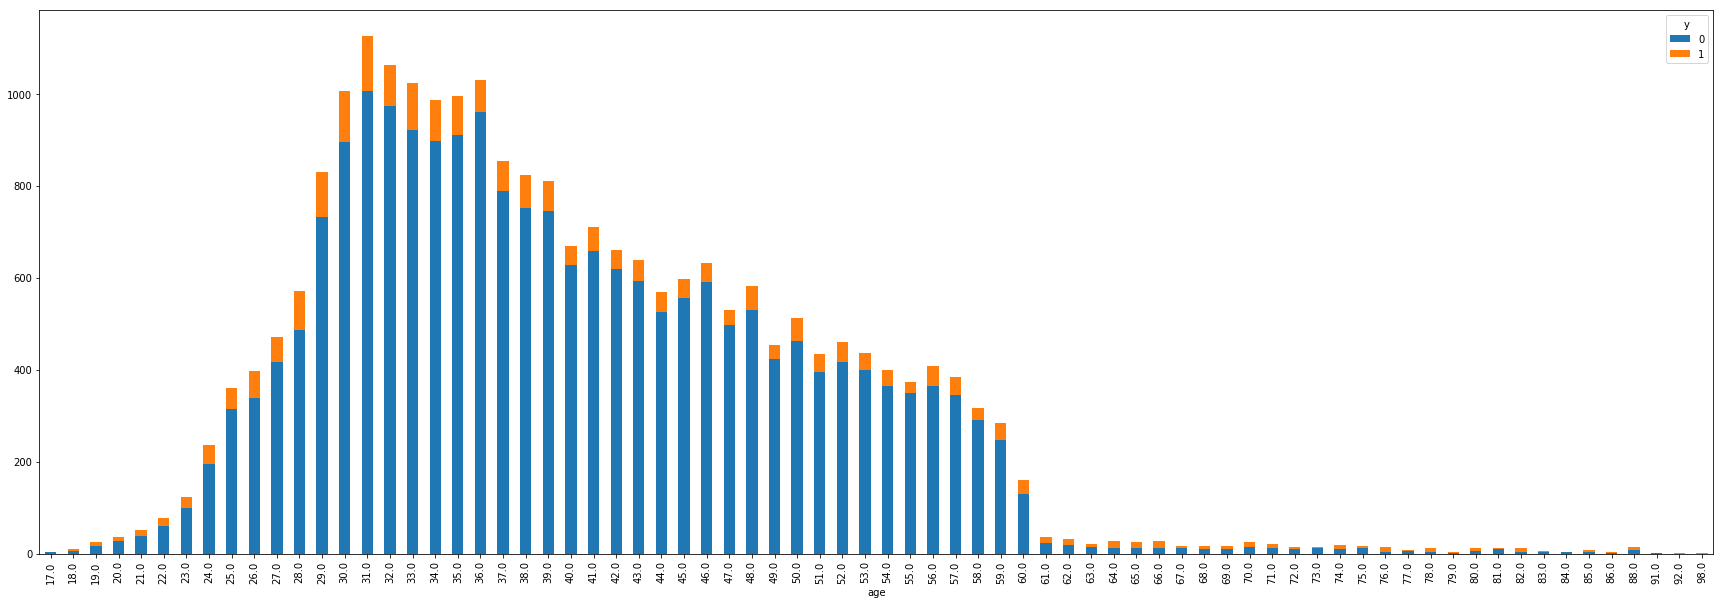

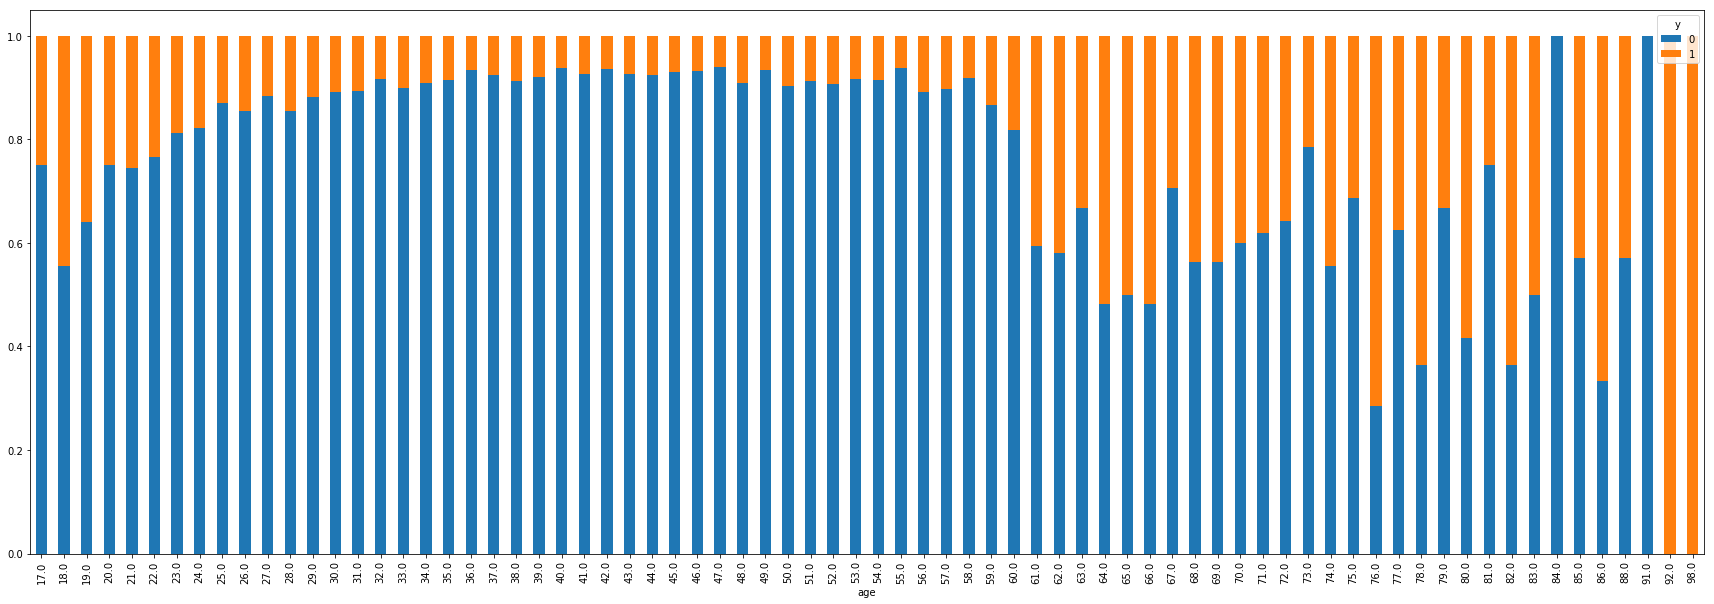

In [27]:
# age effect
c_data = data[data.campaign==0]
c_df = pd.crosstab(c_data.age, c_data.y)
c_df.plot(kind='bar', figsize=(30, 10), stacked=True)
c_df.div(c_df.sum(axis=1), axis=0).plot(kind='bar', stacked=True, figsize=(30, 10))

# this plot of age vs pickup is clearly showing that young people (< 25) 
# and older people (>60) are taking on the offer, but the bank has very few customers in these age brackets
# In all likelihood, we have found students and retiress again in these plots with higher take up

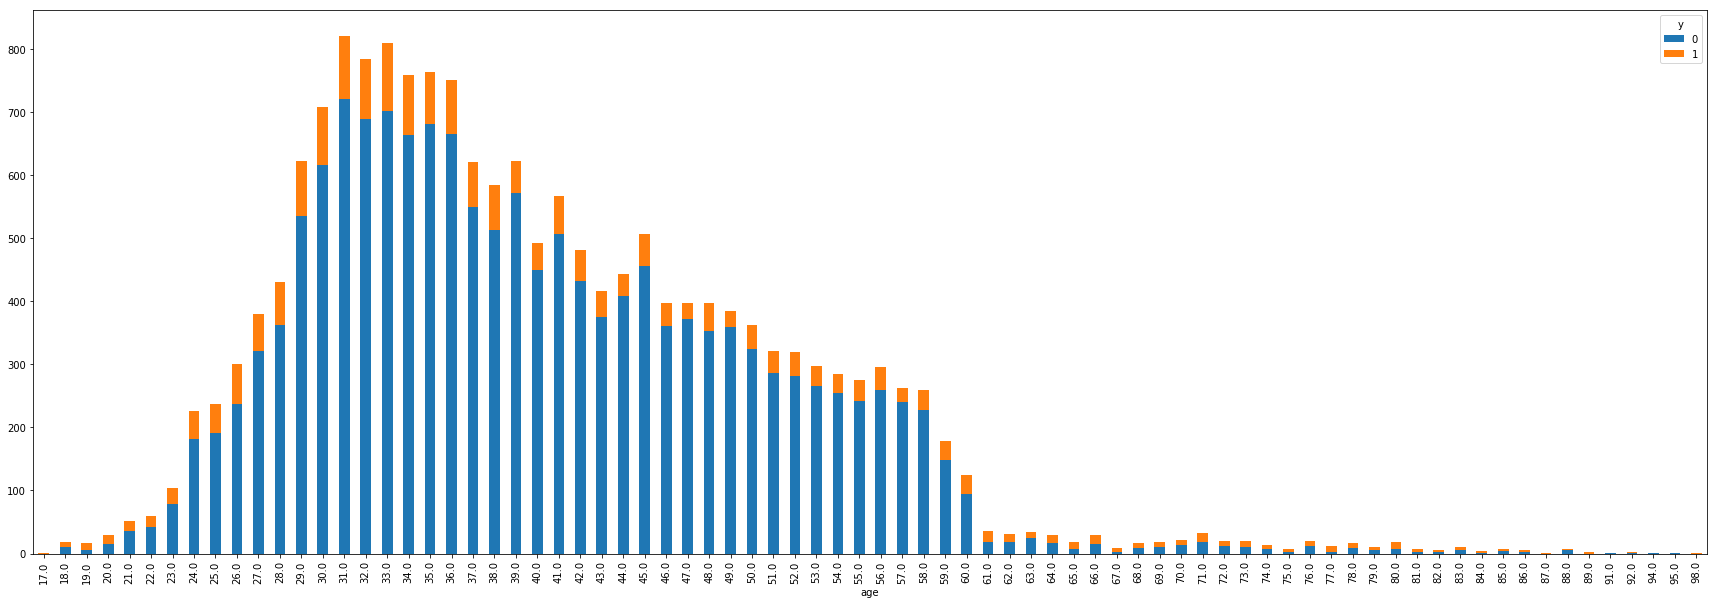

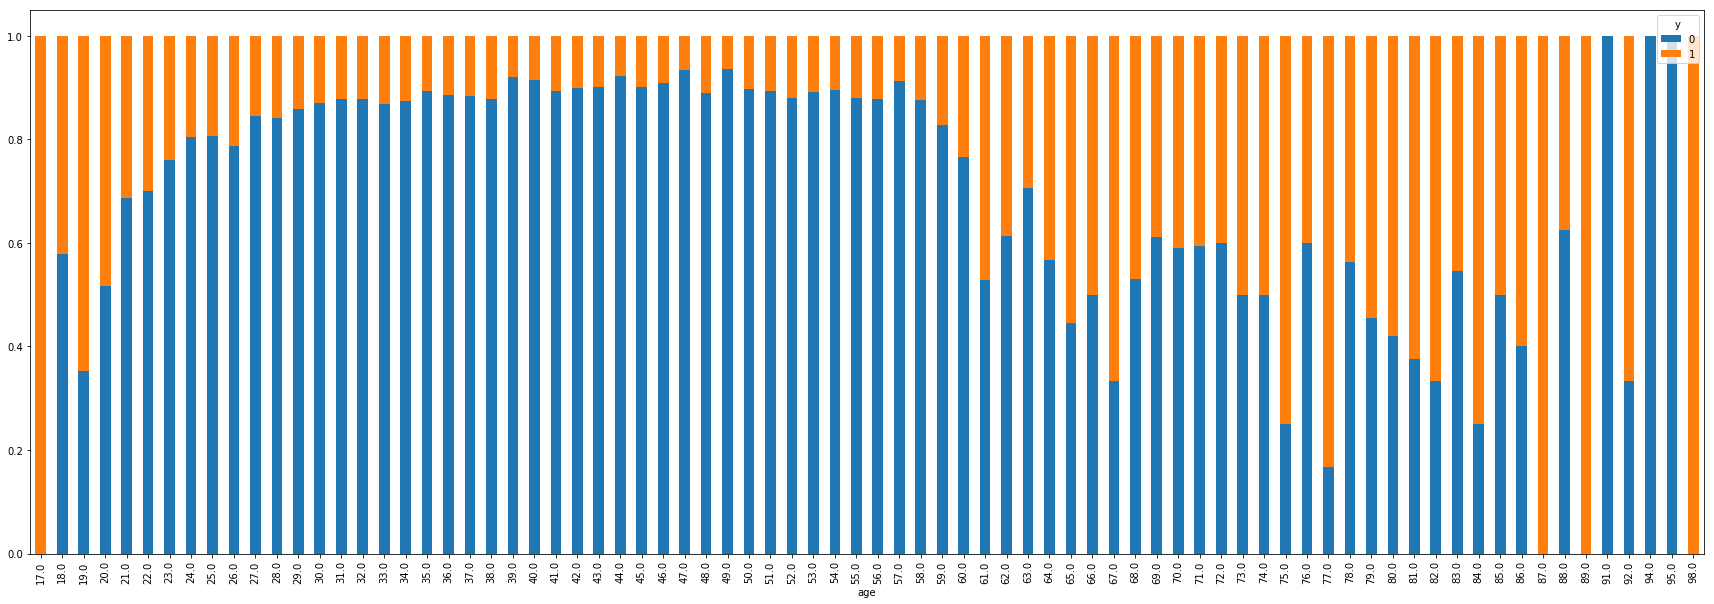

In [28]:
c_data = data[data.campaign==1]
c_df = pd.crosstab(c_data.age, c_data.y)
c_df.plot(kind='bar', stacked=True, figsize=(30, 10))
c_df.div(c_df.sum(axis=1), axis=0).plot(kind='bar', stacked=True, figsize=(30, 10))

# this plot of age vs pickup is clearly showing that young people (< 25) 
# and older people (>60) are taking on the offer

y                  0    1
cons.price.idx           
92.200996        506  264
92.378998        161  106
92.431000        267  180
92.469002        112   66
92.649002        189  168
92.712997         84   88
92.755997          9    1
92.843002        156  126
92.892998       5270  524
92.962997        451  264
93.074997       2016  442
93.199997       3426  190
93.369003        114  150
93.444000       4904  271
93.749001         77   97
93.797997         25   42
93.875999         90  122
93.917999       6278  407
93.994003       7523  240
94.027000        113  120
94.055000        122  107
94.198997        153  150
94.214996        135  176
94.464996       4186  188
94.600998        111   93
94.766998         70   58


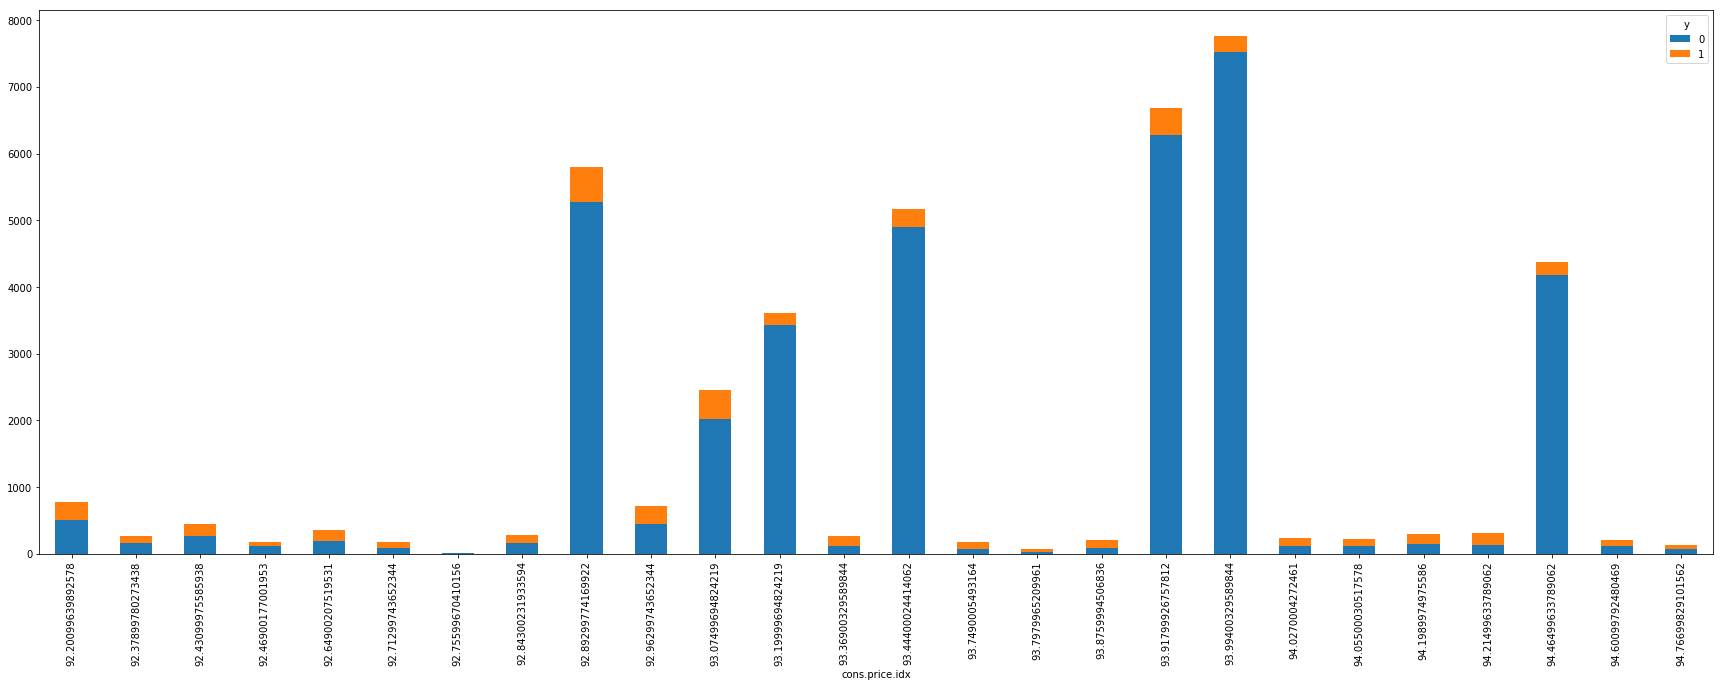

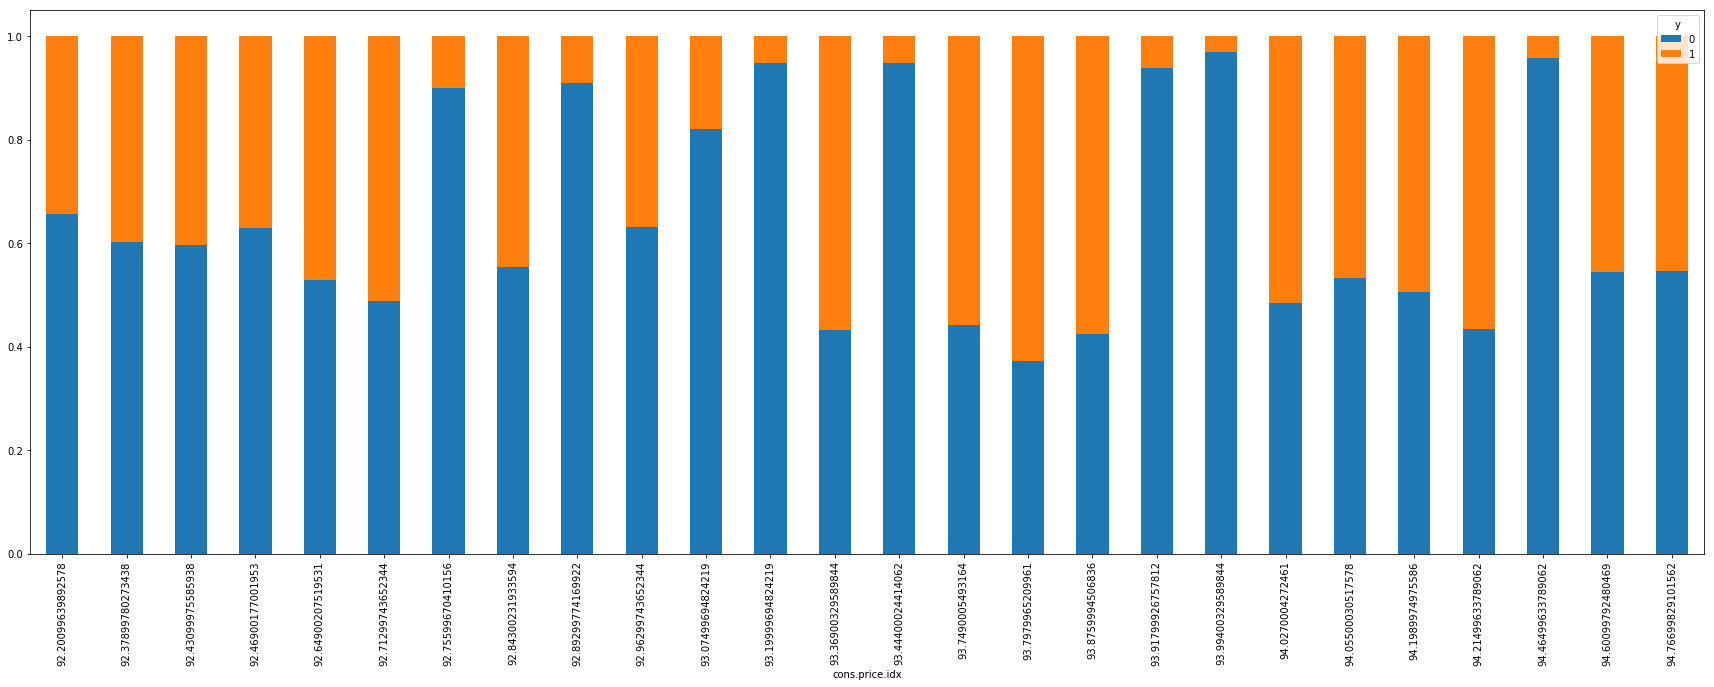

In [42]:
# consumer price index effect effect
c_data = data
c_df = pd.crosstab(c_data['cons.price.idx'], c_data.y)
c_df.plot(kind='bar', figsize=(30, 10), stacked=True)
c_df.div(c_df.sum(axis=1), axis=0).plot(kind='bar', stacked=True, figsize=(30, 10))
# not much effect as the consumer prices index probably did not vary much during the survey.
# Also, what does it mean in the dataset to include a CPI value corresponding to a customer 
# who was not campaigned?, i.e., which CPI, from which date was recorded for this user?

# We are going to ignore this feature in one of the models and see if it helps improve predictability.

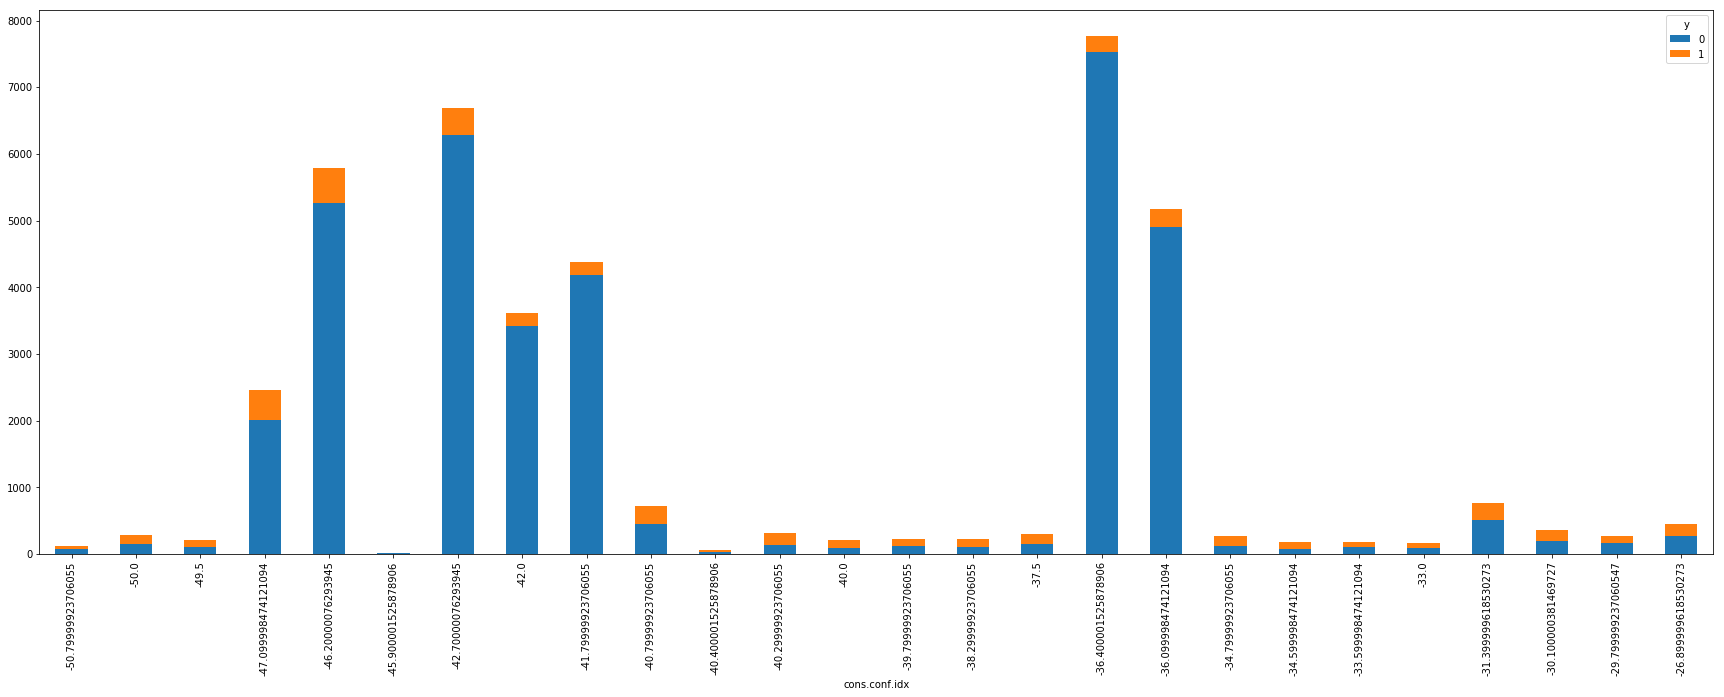

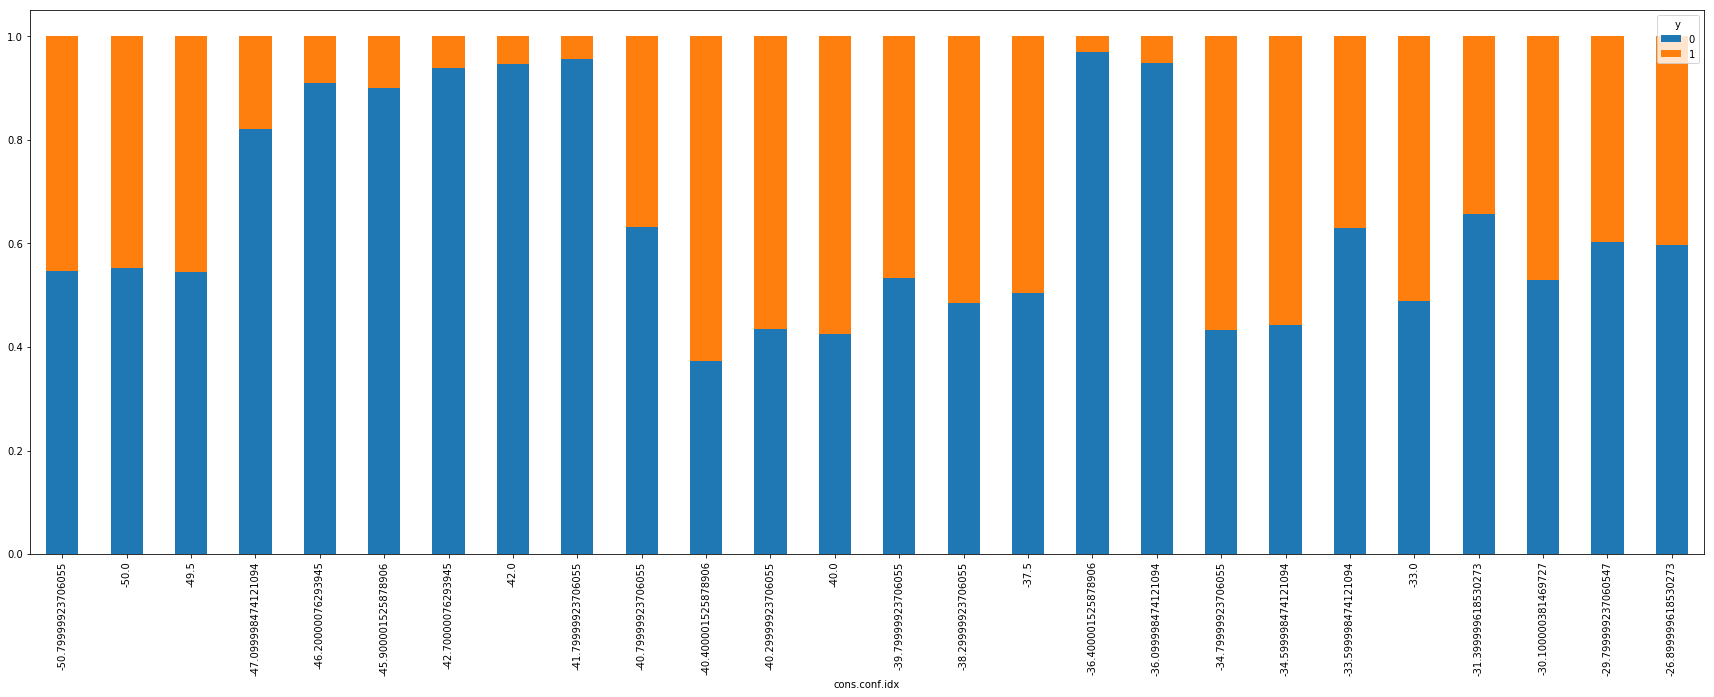

In [33]:
# consumer conf index effect effect
c_data = data
c_df = pd.crosstab(c_data['cons.conf.idx'], c_data.y)
c_df.plot(kind='bar', figsize=(30, 10), stacked=True)
c_df.div(c_df.sum(axis=1), axis=0).plot(kind='bar', stacked=True, figsize=(30, 10))
# not much effect of the consumer confidence index

# Also, what does it mean in the dataset to include a CCI value corresponding to a customer 
# who was not campaigned?, i.e., which CCI, from which date was recorded for this user?

# We are going to ignore this feature in one of the models and see if it helps improve predictability.

y                 0    1
cons.conf.idx           
-50.799999       31   32
-50.000000       64   52
-49.500000       54   54
-47.099998      990  257
-46.200001     2254  257
-45.900002        9    1
-42.700001     2305  139
-42.000000     1755  117
-41.799999     1444   56
-40.799999      267  134
-40.400002       25   42
-40.299999       69   78
-40.000000       53   62
-39.799999       81   61
-38.299999       66   65
-37.500000       87   77
-36.400002     3044   96
-36.099998     1936   90
-34.799999       47   90
-34.599998       27   51
-33.599998       53   30
-33.000000       35   38
-31.400000      300  139
-30.100000       86   98
-29.799999       94   70
-26.900000      166  114


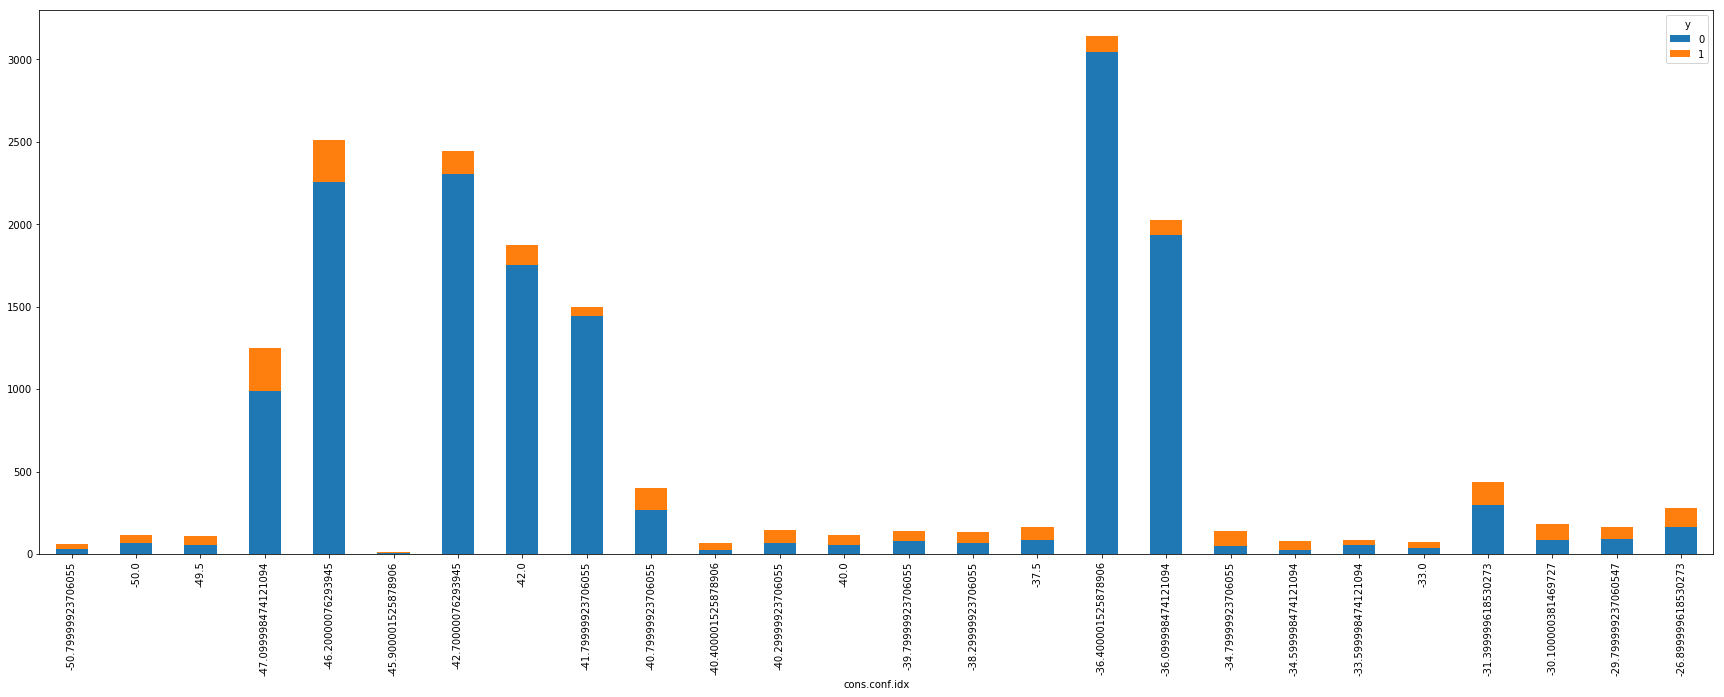

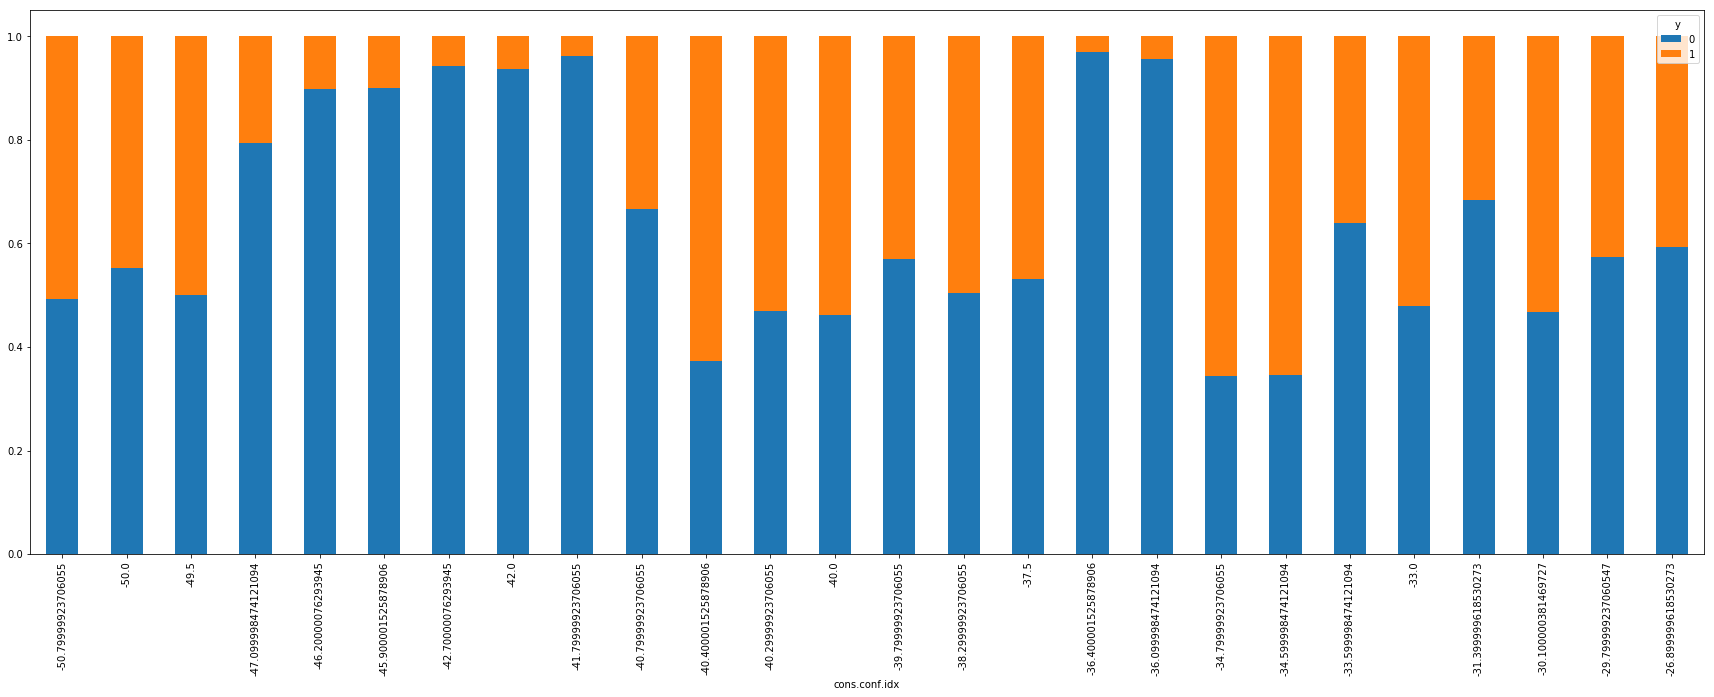

In [41]:
# consumer conf index effect for capmaigned users
c_data = data[data.campaign==1]
c_df = pd.crosstab(c_data['cons.conf.idx'], c_data.y)
c_df.plot(kind='bar', figsize=(30, 10), stacked=True)
c_df.div(c_df.sum(axis=1), axis=0).plot(kind='bar', stacked=True, figsize=(30, 10))
# not much effect of the consumer confidence index
print(c_df)

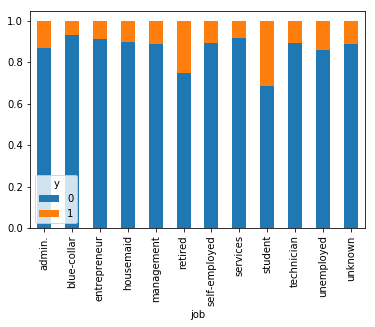

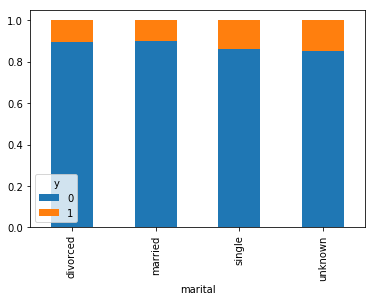

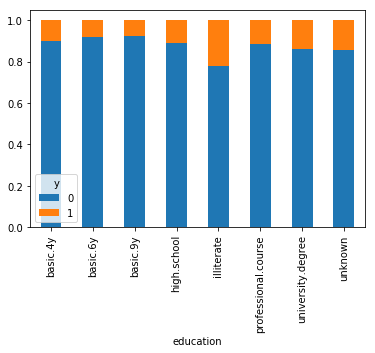

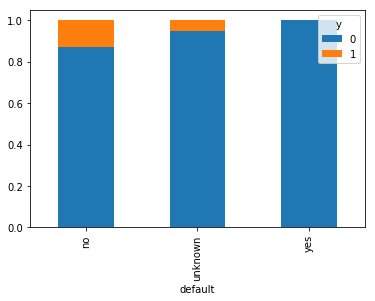

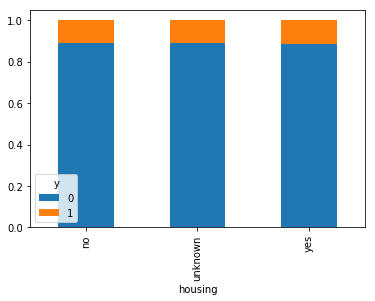

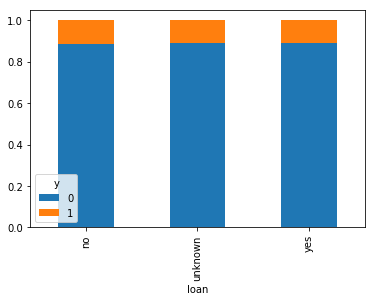

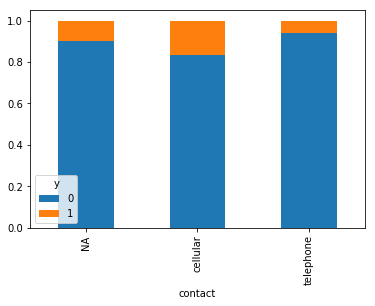

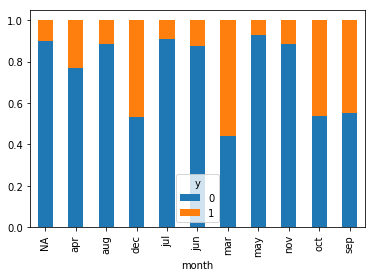

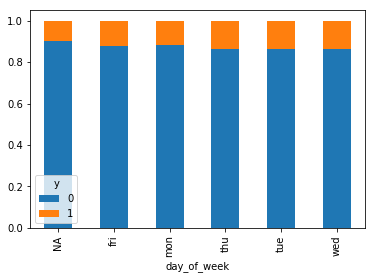

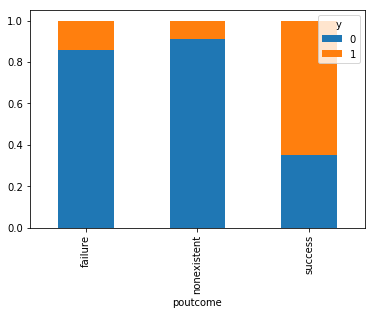

In [31]:
# some exploration of the data to understand which features are important
for c in categorical_features:
    c_df = pd.crosstab(data[c], data.y)
    c_df.div(c_df.sum(axis=1), axis=0).plot(kind='bar', stacked=True)


In [32]:
# feature selection helper by inspecting scatter plots
def plot_features_vs_each_other(X, y, c1, c2):
    x1 = X[c1]
    y2 = X[c2]
    plt.scatter(x1, y2, alpha=0.7, c=y)
    plt.xlabel(c1)
    plt.ylabel(c2)


def plot_roc(clf, X_test, y_test):
    _roc_auc = roc_auc_score(y_test, clf.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
    plt.figure()
    plt.plot(fpr, tpr, label=clf.__class__ + ' (area = %0.2f)'.format(_roc_auc))
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")  
    